# ShapeFactor

In [1]:
import logging
import json
import numpy as np
import matplotlib.pyplot as plt

import pyhf
import pyhf.contrib.viz.brazil

logging.basicConfig(level=logging.INFO)

In [2]:
def prep_data(sourcedata):
    spec = {
        'channels': [
            {
                'name': 'signal',
                'samples': [
                    {
                        'name': 'signal',
                        'data': sourcedata['signal']['bindata']['sig'],
                        'modifiers': [
                            {'name': 'mu', 'type': 'normfactor', 'data': None}
                        ],
                    },
                    {
                        'name': 'bkg1',
                        'data': sourcedata['signal']['bindata']['bkg1'],
                        'modifiers': [
                            {
                                'name': 'coupled_shapefactor',
                                'type': 'shapefactor',
                                'data': None,
                            }
                        ],
                    },
                ],
            },
            {
                'name': 'control',
                'samples': [
                    {
                        'name': 'background',
                        'data': sourcedata['control']['bindata']['bkg1'],
                        'modifiers': [
                            {
                                'name': 'coupled_shapefactor',
                                'type': 'shapefactor',
                                'data': None,
                            }
                        ],
                    }
                ],
            },
        ]
    }
    pdf = pyhf.Model(spec)
    data = []
    for channel in pdf.config.channels:
        data += sourcedata[channel]['bindata']['data']
    data = data + pdf.config.auxdata
    return data, pdf

In [3]:
source = {
    "channels": {
        "signal": {
            "binning": [2, -0.5, 1.5],
            "bindata": {
                "data": [220.0, 230.0],
                "bkg1": [100.0, 70.0],
                "sig": [20.0, 20.0],
            },
        },
        "control": {
            "binning": [2, -0.5, 1.5],
            "bindata": {"data": [200.0, 300.0], "bkg1": [100.0, 100.0]},
        },
    }
}

data, pdf = prep_data(source['channels'])
print(f'data: {data}')

init_pars = pdf.config.suggested_init()
print(f'expected data: {pdf.expected_data(init_pars)}')

par_bounds = pdf.config.suggested_bounds()

INFO:pyhf.pdf:Validating spec against schema: model.json
INFO:pyhf.pdf:adding modifier mu (1 new nuisance parameters)
INFO:pyhf.pdf:adding modifier coupled_shapefactor (2 new nuisance parameters)


data: [200.0, 300.0, 220.0, 230.0]
expected data: [100. 100. 120.  90.]


In [4]:
print(f'initialization parameters: {pdf.config.suggested_init()}')

unconpars = pyhf.infer.mle.fit(data, pdf)
print(f'parameters post unconstrained fit: {unconpars}')

initialization parameters: [1.0, 1.0, 1.0]
parameters post unconstrained fit: [1.00004623 1.99998941 3.00000438]


/srv/conda/envs/notebook/lib/python3.7/site-packages/pyhf/tensor/numpy_backend.py:334: RuntimeWarning: divide by zero encountered in log
  return n * np.log(lam) - lam - gammaln(n + 1.0)


In [5]:
obs_limit, exp_limits, (poi_tests, tests) = pyhf.infer.intervals.upperlimit(
    data, pdf, np.linspace(0, 5, 61), level=0.05, return_results=True
)

/srv/conda/envs/notebook/lib/python3.7/site-packages/pyhf/infer/calculators.py:352: RuntimeWarning: invalid value encountered in double_scalars
  teststat = (qmu - qmu_A) / (2 * self.sqrtqmuA_v)


expected upper limits: [array(0.74138115), array(0.994935), array(1.38451391), array(1.92899382), array(2.59407668)]
observed upper limit : 2.1945969322493744


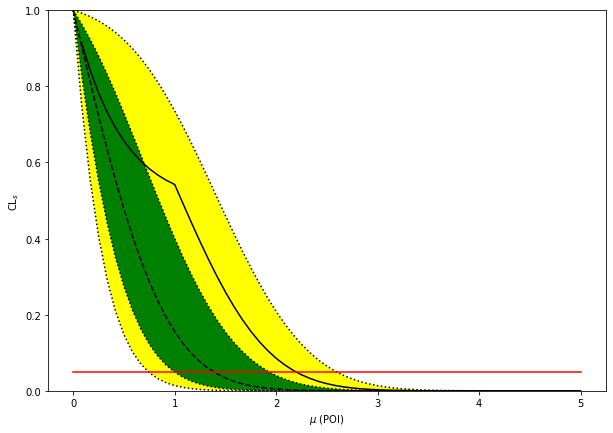

In [6]:
fig, ax = plt.subplots(figsize=(10, 7))
pyhf.contrib.viz.brazil.plot_results(ax, poi_tests, tests, test_size=0.05)
print(f'expected upper limits: {exp_limits}')
print(f'observed upper limit : {obs_limit}')